# EDA YELLOW TAXIS
`En este cuadernillo se realiza el análisis exploratorio del dataset 'yellow_to_go_eda.parquet'`

### Importación de librerías
---

*Para este cuaderno usaremos las siguientes librerías: **pandas, numpy, os, matplotlib, pathlib, seaborn, selenium y BeautifulSoup4**.*

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
from pathlib import Path
from selenium import webdriver
from bs4 import BeautifulSoup
import requests

#### Web Scraping / Extracción de los datos
---
1. Utilizaremos principalmente las librerías Selenium y BeautifulSoup para obtener archivos contenidos en la web 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page', que tienen información acerca de viajes de taxis y aplicaciones móviles de la ciudad de Nueva York.

2. Estos archivos son descargados y almacenados localmente para su análisis y son convertidos a un dataframe de Pandas.

In [ ]:
class DatasetDownloader:
    def __init__(self, base_url, download_folder):
        self.base_url = base_url
        self.download_folder = Path(download_folder)
        # Asegúrate de que el directorio de descarga exista
        self.download_folder.mkdir(parents=True, exist_ok=True)

    def scrape_urls(self):
        # Inicializar el navegador Selenium
        driver = webdriver.Chrome()  # Necesitarás el driver de Chrome. Descárgalo de https://sites.google.com/a/chromium.org/chromedriver/downloads

        # Obtener el contenido de la página web con Selenium
        driver.get(self.base_url)
        page_source = driver.page_source

        # Parsear el contenido con BeautifulSoup
        soup = BeautifulSoup(page_source, 'html.parser')
        links = soup.find_all('a')

        file_urls = {}
        for link in links:
            href = link.get('href')
            if href:
                # Eliminar espacios adicionales en los enlaces
                href = href.strip()
                if any(year in href for year in ['2022', '2023']) or 'taxi_zone_lookup' in href or 'taxi_zones' in href: #in ['2021', '2022', '2023']) 
                    if href.endswith(('.zip', '.xlsx', '.csv', '.gz', '.geojson', '.pdf', '.parquet')):
                        file_name = href.split('/')[-1]
                        file_urls[file_name] = href

        # Cerrar el navegador Selenium
        driver.quit()

        return file_urls
    
    def download_file(self, url, save_path):
        try:
            if not save_path.exists():
                response = requests.get(url, stream=True)
                response.raise_for_status()
                with open(save_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"Archivo guardado: {save_path}")
            else:
                print(f"El archivo {save_path} ya existe, no es necesario descargarlo nuevamente.")
        except Exception as e:
            print(f"Error al descargar el archivo: {url}")
            print(f"Error details: {e}")

    def download_datasets(self):
        file_urls_dict = self.scrape_urls()
        for file_name, url in file_urls_dict.items():
            save_path = self.download_folder / file_name
            self.download_file(url, save_path)


# Uso de ejemplo
base_url = 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
download_folder = '../datasets/raw'
downloader = DatasetDownloader(base_url, download_folder)
downloader.download_datasets()

In [2]:
df_yellow = pd.read_parquet('../../datasets/raw/yellow_to_go_eda.parquet')

### Análisis exploratorio inicial
---

*Realizaremos una **exploración de los datos** (EDA) antes de hacer transformación de los mismos, esto con el fin de **conocer las columnas** y determinar que campos son importantes para nuestro análisis y así tener claridad con los pasos a seguir en el ETL.*

**Nota:**: *Posterior al ETL realizaremos también un EDA enfocado en los datos y una descripción estadística.*

#### **Revisión de la extracción de los datos** ####

*Revisamos que los datos se cargaron adecuadamente en nuestro dataframe **df_yellow**:*

1. *Usamos **head** para previsualizar los primeros registros del Dataframe.*

In [3]:
df_yellow.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,pickup_hour,duracion_viaje,pickup_date
0,1,2,3.80,1,142,236,1,21.95,0,1069,2022-01-01
1,1,1,2.10,1,236,42,1,13.30,0,504,2022-01-01
2,2,1,0.97,1,166,166,1,10.56,0,538,2022-01-01
3,2,1,1.09,1,114,68,2,11.80,0,602,2022-01-01
4,2,1,4.30,1,68,163,1,30.30,0,2252,2022-01-01


#### **Revisión de la forma de los datos** ####

1. *Usamos **shape** obtener el número de filas y columnas del dataframe.*
2. *Observamos que actualmente tenemos 71649264 registros y 11 columnas*

In [4]:
df_yellow.shape

(71649264, 11)

#### **Exploración de las columnas** ####

*Vamos a revisar qué columnas existen en el dataframe y de qué tipo son:*

1. *Usamos el método **info()** para listar las columnas.*

In [5]:
df_yellow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71649264 entries, 0 to 77786320
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   VendorID         int32         
 1   passenger_count  int32         
 2   trip_distance    float64       
 3   RatecodeID       int32         
 4   PULocationID     int32         
 5   DOLocationID     int32         
 6   payment_type     int32         
 7   total_amount     float64       
 8   pickup_hour      int32         
 9   duracion_viaje   int32         
 10  pickup_date      datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(8)
memory usage: 4.3 GB


In [7]:
df_yellow.isnull().sum()

VendorID           0
passenger_count    0
trip_distance      0
RatecodeID         0
PULocationID       0
DOLocationID       0
payment_type       0
total_amount       0
pickup_hour        0
duracion_viaje     0
pickup_date        0
dtype: int64

#### **Búsqueda y eliminación de duplicados** ####

*Revisamos los registros que pudieran estar duplicados basados en todas las columnas:*

1. *Usamos el método **drop_duplicates()***
2. *Observamos la cantidad de registros posterior a la eliminación de duplicados*

In [6]:
df_sin_duplicados = df_yellow.drop_duplicates()

df_sin_duplicados.shape

(71645092, 11)

##### **Revisamos cada una de las columnas** ####

*Con el fin de explorar a nivel de detalle el dataset obtenido realizamos un análisis por columna con el fin de tomar decisiones sobre la ideonidad de los datos y depurar información innecesaria.*

In [7]:
df_sin_duplicados.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'total_amount',
       'pickup_hour', 'duracion_viaje', 'pickup_date'],
      dtype='object')

In [8]:
# Modificamos nombres de columnas
renombrar = {'VendorID': 'IdProveedor',
             'PULocationID': 'IdZonaOrigen',
             'DOLocationID': 'IdZonaDestino',
             'pickup_date': 'FechaRecogida',
             'pickup_hour': 'HoraRecogida',
             'duracion_viaje': 'DuracionViaje',
             'trip_distance': 'DistanciaViaje',
             'passenger_count': 'TotalPasajeros',
             'RatecodeID': 'TipoTarifa',
             'payment_type': 'TipoPago',
             'total_amount': 'CostoTotal'}

df_sin_duplicados = df_sin_duplicados.rename(columns=renombrar)

df_sin_duplicados.columns

Index(['IdProveedor', 'TotalPasajeros', 'DistanciaViaje', 'TipoTarifa',
       'IdZonaOrigen', 'IdZonaDestino', 'TipoPago', 'CostoTotal',
       'HoraRecogida', 'DuracionViaje', 'FechaRecogida'],
      dtype='object')

In [9]:
df_sin_duplicados

,IdProveedor,TotalPasajeros,DistanciaViaje,TipoTarifa,IdZonaOrigen,IdZonaDestino,TipoPago,CostoTotal,HoraRecogida,DuracionViaje,FechaRecogida
0,1,2,3.80,1,142,236,1,21.95,0,1069,2022-01-01
1,1,1,2.10,1,236,42,1,13.30,0,504,2022-01-01
2,2,1,0.97,1,166,166,1,10.56,0,538,2022-01-01
3,2,1,1.09,1,114,68,2,11.80,0,602,2022-01-01
4,2,1,4.30,1,68,163,1,30.30,0,2252,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...
77786316,1,1,2.60,1,170,236,1,26.40,23,1088,2023-12-31
77786317,1,1,0.60,1,236,237,1,12.12,23,163,2023-12-31
77786318,1,1,3.80,1,161,7,1,29.75,23,1083,2023-12-31
77786319,1,2,3.10,1,79,141,1,23.85,23,630,2023-12-31


**Columna TotalPasajeros**

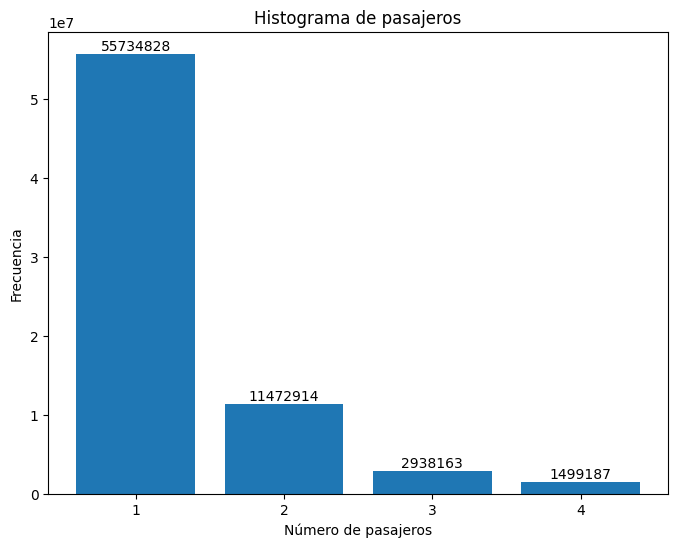

In [10]:
# Se calcula la cantidad de ocurrencias de cada valor de passenger_count
conteo_pasajeros = df_sin_duplicados['TotalPasajeros'].value_counts().reset_index()
conteo_pasajeros.columns = ['TotalPasajeros', 'count']

# Se crea el histograma utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(conteo_pasajeros['TotalPasajeros'], conteo_pasajeros['count'])

# Se agrega etiquetas de cantidad en cada barra con un salto de 1 en 1
for index, row in conteo_pasajeros.iterrows():
    plt.annotate(row['count'], xy=(row['TotalPasajeros'], row['count']), ha='center', va='bottom')

# Se configuran títulos y etiquetas de ejes
plt.title('Histograma de pasajeros')
plt.xlabel('Número de pasajeros')
plt.ylabel('Frecuencia')

# Se establecen el eje x con valores enteros
plt.xticks(range(min(conteo_pasajeros['TotalPasajeros']), max(conteo_pasajeros['TotalPasajeros']) + 1))

# Se muestra el gráfico
plt.show()

**Columna DistanciaViaje**

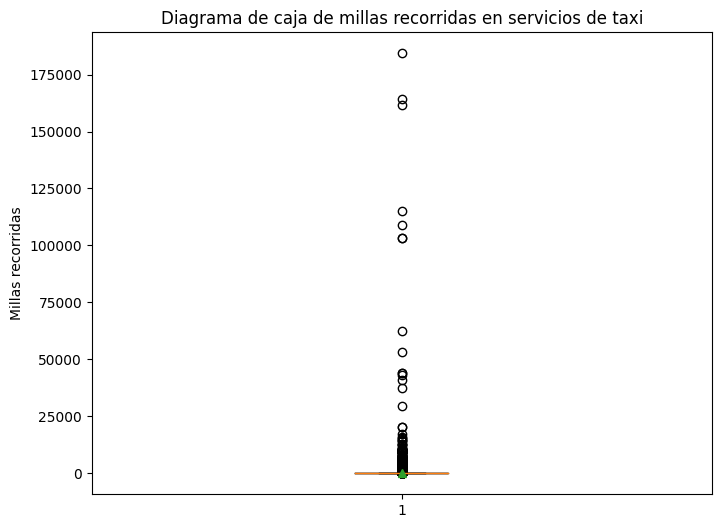

In [11]:
# Se crea el diagrama de caja utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(df_sin_duplicados['DistanciaViaje'], showmeans=True)

# Se configuran títulos y etiquetas de ejes
plt.title('Diagrama de caja de millas recorridas en servicios de taxi')
plt.ylabel('Millas recorridas')

# Se muestra el gráfico
plt.show()

In [12]:
#Se eliminan los valores del campo 'trip_distance' menores a 0.5 y mayores a 40 considerados como outliers
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['DistanciaViaje'] < 0.5 ].index, inplace=True)
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['DistanciaViaje'] >  40 ].index, inplace=True)

In [14]:
# Se calcula la media, mediana, desviación estándar, mínimo y máximo de la columna 'trip_distance'
mean_seconds = df_sin_duplicados['DistanciaViaje'].mean()
median_seconds = df_sin_duplicados['DistanciaViaje'].median()
std_seconds = df_sin_duplicados['DistanciaViaje'].std()
min_seconds = df_sin_duplicados['DistanciaViaje'].min()
max_seconds = df_sin_duplicados['DistanciaViaje'].max()

# Se revisan los resultados
print("Minimo:", min_seconds)
print("Maximo:", max_seconds)
print("Media:", mean_seconds)
print("Mediana:", median_seconds)
print("Desviación estándar:", std_seconds)

#Se obtienen las dimensiones del dataframe
print(f'\nDimensiones df_sin_duplicados: {df_sin_duplicados.shape}')

Minimo: 0.5
Maximo: 40.0
Media: 3.6026960813694187
Mediana: 1.9
Desviación estándar: 4.476101588539747

Dimensiones df_sin_duplicados: (68239094, 11)


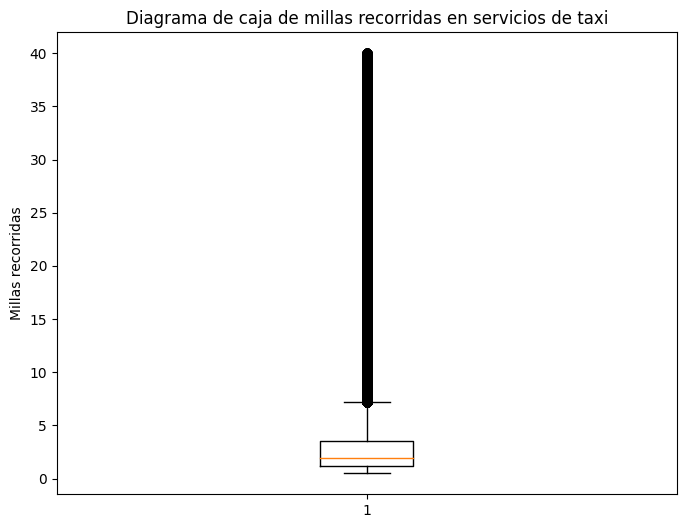

In [15]:
# Creamos el diagrama de caja utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(df_sin_duplicados['DistanciaViaje'])

# Configuramos títulos y etiquetas de ejes
plt.title('Diagrama de caja de millas recorridas en servicios de taxi')
plt.ylabel('Millas recorridas')

# Se muestra el gráfico
plt.show()

**Columna IdZonaOrigen**

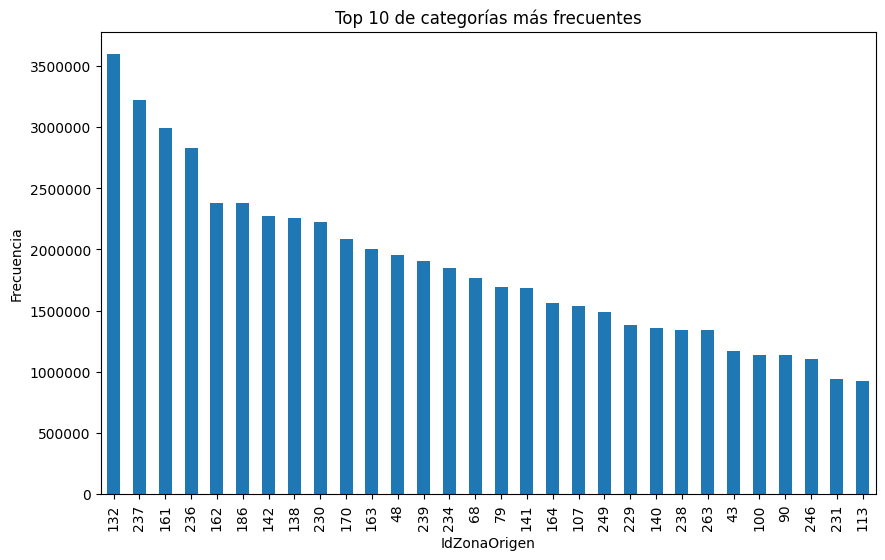

In [16]:
# Se obtiene el top 10 de categorías más frecuentes
top_10_categorias = df_sin_duplicados['IdZonaOrigen'].value_counts().head(30)

# Se crea un gráfico de barras para el top 10 de categorías
plt.figure(figsize=(10, 6))
top_10_categorias.plot(kind='bar')
plt.title('Top 10 de categorías más frecuentes')
plt.xlabel('IdZonaOrigen')
plt.ylabel('Frecuencia')

# Se desactivan la notación científica en el eje Y y mostrar los valores como enteros completos
plt.ticklabel_format(style='plain', axis='y')

plt.show()

**Columna IdZonaDestino**

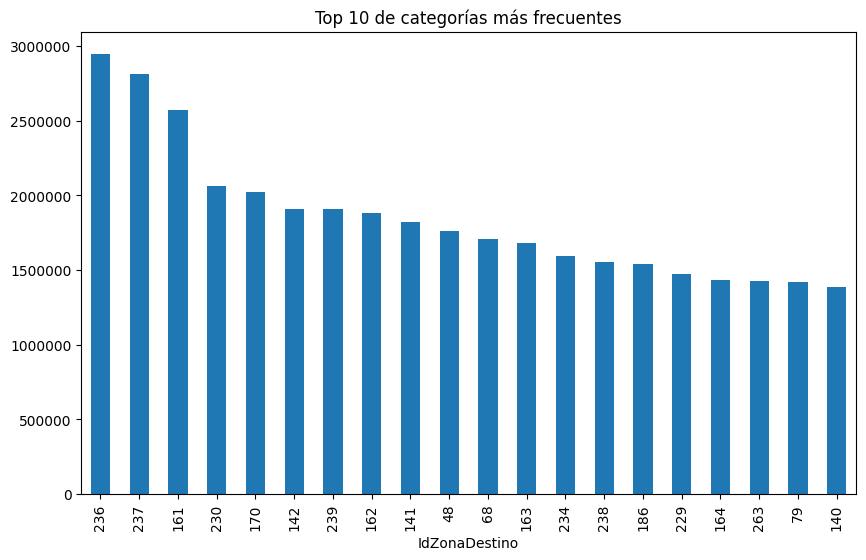

In [17]:
# Se obtiene el top 10 de categorías más frecuentes
top_10_categorias = df_sin_duplicados['IdZonaDestino'].value_counts().head(20)

# Se crea un gráfico de barras para el top 10 de categorías
plt.figure(figsize=(10, 6))
top_10_categorias.plot(kind='bar')
plt.title('Top 10 de categorías más frecuentes')
plt.xlabel('IdZonaDestino')

# Se desactiva la notación científica en el eje Y y mostrar los valores como enteros completos
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [16]:
'''  # Creamos una nueva columna 'key' basada en las combinaciones de IdZonaOrigen y IdZonaDestino
df_sin_duplicados['key'] = df_sin_duplicados['IdZonaOrigen'].astype(str) + '_' + df_sin_duplicados['IdZonaDestino'].astype(str) ''' 

In [ ]:
''' # Se obtiene el top 10 de categorías más frecuentes
top_10_categorias = df_sin_duplicados['key'].value_counts().tail(30)

# Se crea un gráfico de barras para el top 10 de categorías
plt.figure(figsize=(10, 6))
top_10_categorias.plot(kind='bar')
plt.title('Top 10 de categorías más frecuentes')
plt.xlabel('Categoría')

# Se desactivan la notación científica en el eje Y y mostrar los valores como enteros completos
plt.ticklabel_format(style='plain', axis='y')

plt.show()  '''

In [ ]:
''' df_sin_duplicados.head() '''

**Columna TipoPago**

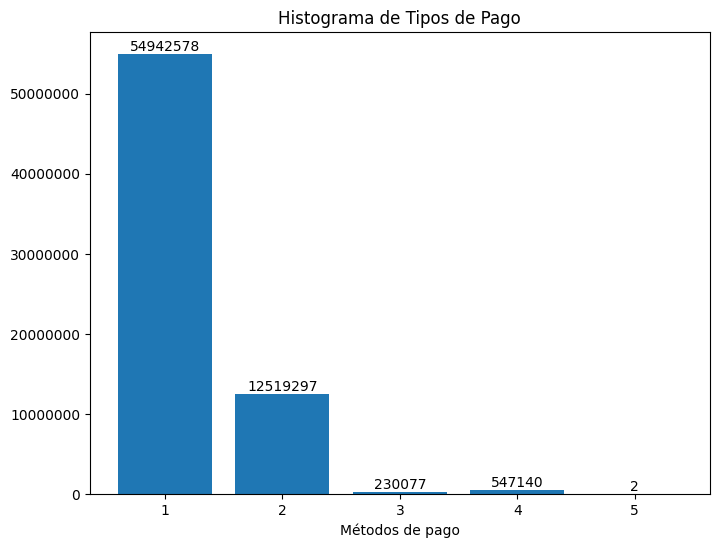

In [18]:
# Calculamos la cantidad de ocurrencias de cada valor de payment_type
conteo_pasajeros = df_sin_duplicados['TipoPago'].value_counts().reset_index()
conteo_pasajeros.columns = ['TipoPago', 'count']

# Creamos el histograma utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(conteo_pasajeros['TipoPago'], conteo_pasajeros['count'])

# Agregamos etiquetas de cantidad en cada barra con un salto de 1 en 1
for index, row in conteo_pasajeros.iterrows():
    plt.annotate(row['count'], xy=(row['TipoPago'], row['count']), ha='center', va='bottom')

# Configuramos títulos y etiquetas de ejes
plt.title('Histograma de Tipos de Pago')
plt.xlabel('Métodos de pago')

# Establecemos el eje x con valores enteros
plt.xticks(range(min(conteo_pasajeros['TipoPago']), max(conteo_pasajeros['TipoPago']) + 1))

# Desactivamos la notación científica en el eje Y y mostrar los valores como enteros completos
plt.ticklabel_format(style='plain', axis='y')

# Mostramos el gráfico
plt.show()

In [19]:
# Eliminamos tipos de pago mayores a 2
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['TipoPago'] > 2 ].index, inplace=True)

#Se obtienen las dimensiones del dataframe
print(f'\nDimensiones df_sin_duplicados: {df_sin_duplicados.shape}')


Dimensiones df_sin_duplicados: (67461875, 11)


**Columna CostoTotal**

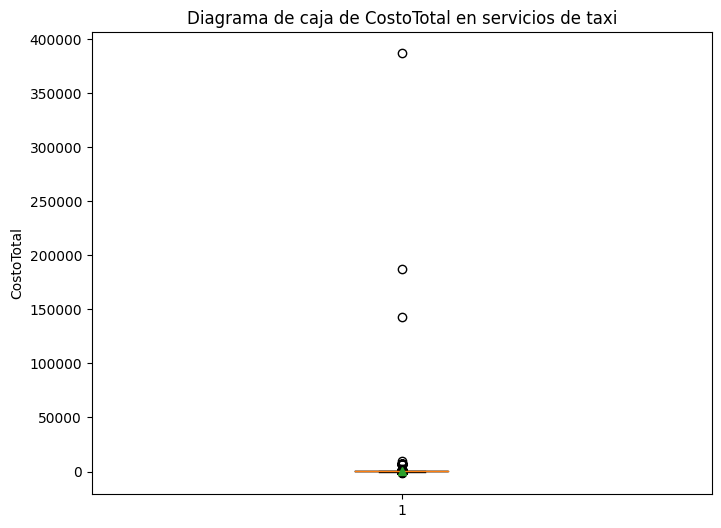

In [20]:
# Se crea el diagrama de caja utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(df_sin_duplicados['CostoTotal'], showmeans=True)

# Se configuran títulos y etiquetas de ejes
plt.title('Diagrama de caja de CostoTotal en servicios de taxi')
plt.ylabel('CostoTotal')

# Se muestra el gráfico
plt.show()

In [21]:
# Calcular la media, mediana, desviación estándar, mínimo y máximo de la columna:  'CostoTotal'
mean_seconds = df_sin_duplicados['CostoTotal'].mean()
median_seconds = df_sin_duplicados['CostoTotal'].median()
std_seconds = df_sin_duplicados['CostoTotal'].std()
min_seconds = df_sin_duplicados['CostoTotal'].min()
max_seconds = df_sin_duplicados['CostoTotal'].max()

# Revisar los resultados
print("Minimo:", min_seconds)
print("Maximo:", max_seconds)
print("Media:", mean_seconds)
print("Mediana:", median_seconds)
print("Desviación estándar:", std_seconds)

Minimo: -1635.8
Maximo: 386987.63
Media: 25.421623952639838
Mediana: 18.59
Desviación estándar: 59.06571990343791


In [22]:
# Calcular los cuartiles para las columna 'total_amount'
cuartiles_total_amount = np.percentile(df_sin_duplicados['CostoTotal'], [10, 50, 90])
print(cuartiles_total_amount)

[11.3  18.59 50.25]


In [23]:
# Eliminamos valores del campo 'CostoTotal' considerados como outliers
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['CostoTotal'] < 11.3 ].index, inplace=True)
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['CostoTotal'] >  50.25 ].index, inplace=True)

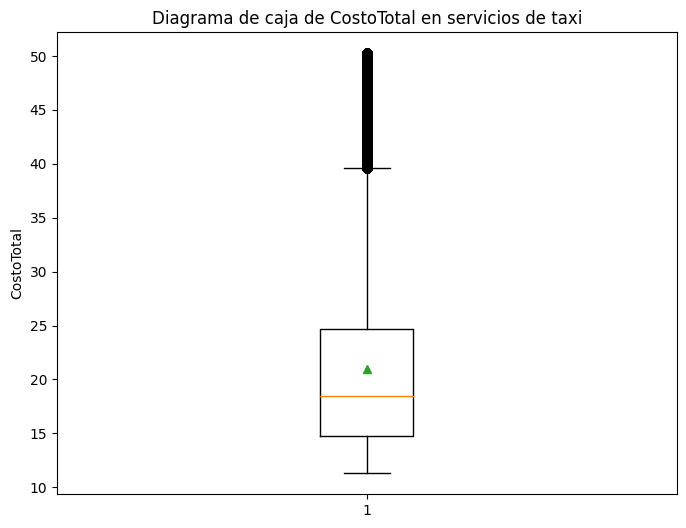

In [25]:
# e crea el diagrama de caja utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(df_sin_duplicados['CostoTotal'], showmeans=True)

# Se configuran títulos y etiquetas de ejes
plt.title('Diagrama de caja de CostoTotal en servicios de taxi')
plt.ylabel('CostoTotal')

# Mostrar el gráfico
plt.show()

In [26]:
#Se obtienen las dimensiones del dataframe
print(f'Dimensiones df_sin_duplicados: {df_sin_duplicados.shape}')

Dimensiones df_sin_duplicados: (54425690, 11)


**Columna HoraRecogida**

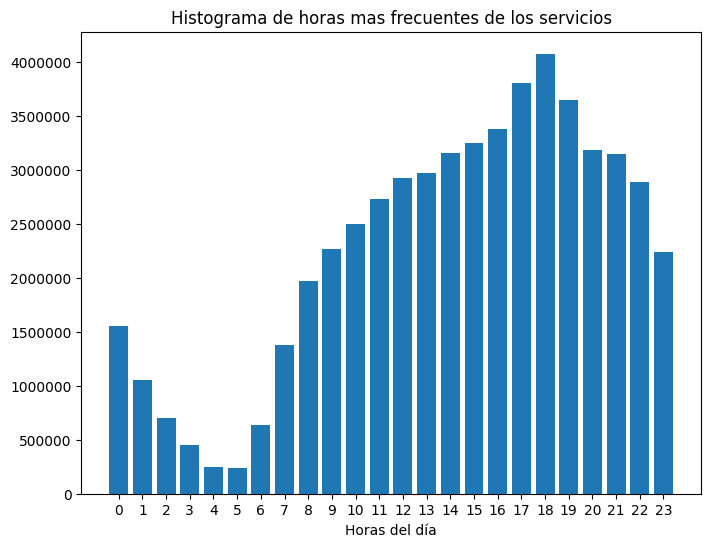

In [27]:
# Calcular la cantidad de ocurrencias de cada valor de pickup_hour
conteo_pasajeros = df_sin_duplicados['HoraRecogida'].value_counts().reset_index()
conteo_pasajeros.columns = ['HoraRecogida', 'count']

# Crear el histograma utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(conteo_pasajeros['HoraRecogida'], conteo_pasajeros['count'])

# Configurar títulos y etiquetas de ejes
plt.title('Histograma de horas mas frecuentes de los servicios')
plt.xlabel('Horas del día')

# Establecer el eje x con valores enteros
plt.xticks(range(min(conteo_pasajeros['HoraRecogida']), max(conteo_pasajeros['HoraRecogida']) + 1))

# Desactivar la notación científica en el eje Y y mostrar los valores como enteros completos
plt.ticklabel_format(style='plain', axis='y')

# Mostrar el gráfico
plt.show()

**Columna DuracionViaje**

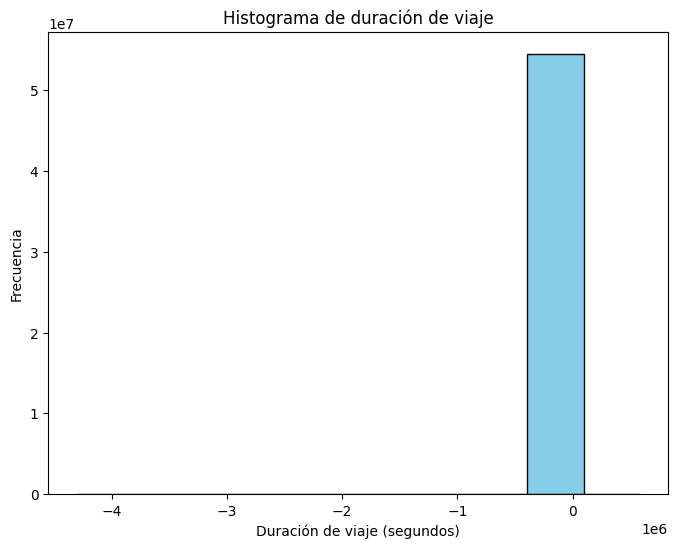

In [28]:
# Crear un histograma de duración de viaje
plt.figure(figsize=(8, 6))
plt.hist(df_sin_duplicados['DuracionViaje'], bins=10, color='skyblue', edgecolor='black')

# Configurar títulos y etiquetas de ejes
plt.title('Histograma de duración de viaje')
plt.xlabel('Duración de viaje (segundos)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

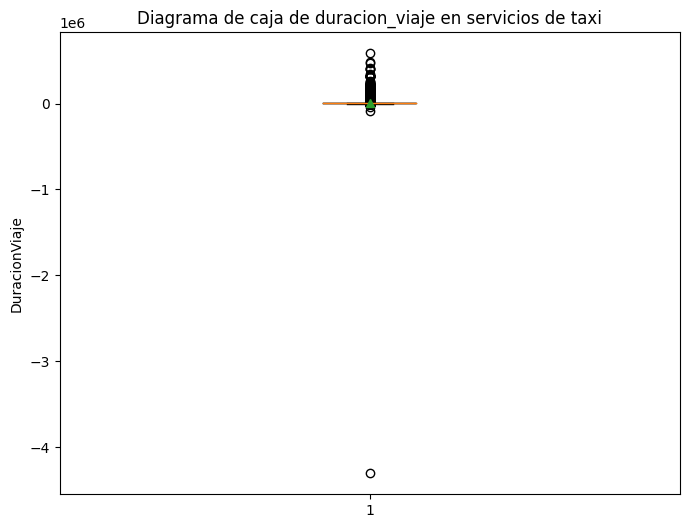

In [29]:
# Crear el diagrama de caja utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(df_sin_duplicados['DuracionViaje'], showmeans=True)

# Configurar títulos y etiquetas de ejes
plt.title('Diagrama de caja de duracion_viaje en servicios de taxi')
plt.ylabel('DuracionViaje')

# Mostrar el gráfico
plt.show()

In [30]:
# Calcular la media, mediana, desviación estándar, mínimo y máximo de la columna:  'duracion_viaje'
mean_seconds = df_sin_duplicados['DuracionViaje'].mean()
median_seconds = df_sin_duplicados['DuracionViaje'].median()
std_seconds = df_sin_duplicados['DuracionViaje'].std()
min_seconds = df_sin_duplicados['DuracionViaje'].min()
max_seconds = df_sin_duplicados['DuracionViaje'].max()

# Revisar los resultados
print("Minimo:", min_seconds)
print("Maximo:", max_seconds)
print("Media:", mean_seconds)
print("Mediana:", median_seconds)
print("Desviación estándar:", std_seconds)

Minimo: -4305596
Maximo: 584823
Media: 945.3337317726243
Mediana: 762.0
Desviación estándar: 2659.561139832486


In [31]:
# Calcular los cuartiles para las columnas 'total_amount' y 'duracion_viaje'
cuartiles_total_amount = np.percentile(df_sin_duplicados['DuracionViaje'], [5, 50, 95])
print(cuartiles_total_amount)

[ 310.  762. 1782.]


In [32]:
# Contar los registros con duración de viaje inferior a 310 segundos
registros_inferiores_a_310 = df_sin_duplicados[df_sin_duplicados['DuracionViaje'] < 310 ]
cantidad_registros_inferiores_a_310 = len(registros_inferiores_a_310)
print("Cantidad de registros con duracion_viaje inferior a 310 :", cantidad_registros_inferiores_a_310)

Cantidad de registros con duracion_viaje inferior a 310 : 2700769


In [33]:
# Contar los registros con duración de viaje mayor a 2700 segundos
registros_superiores_a_2700 = df_sin_duplicados[df_sin_duplicados['DuracionViaje'] > 2700 ]
cantidad_registros_superiores_a_2700 = len(registros_superiores_a_2700)
print("Cantidad de registros con DuracionViaje superior a 2700 :", cantidad_registros_superiores_a_2700)

Cantidad de registros con DuracionViaje superior a 2700 : 253019


In [35]:
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['DuracionViaje'] < 310 ].index, inplace=True)
df_sin_duplicados.drop(df_sin_duplicados[df_sin_duplicados['DuracionViaje'] >  2700 ].index, inplace=True)

#Se obtienen las dimensiones del dataframe
print(f'Dimensiones df_sin_duplicados: {df_sin_duplicados.shape}')

Dimensiones df_sin_duplicados: (51471902, 11)


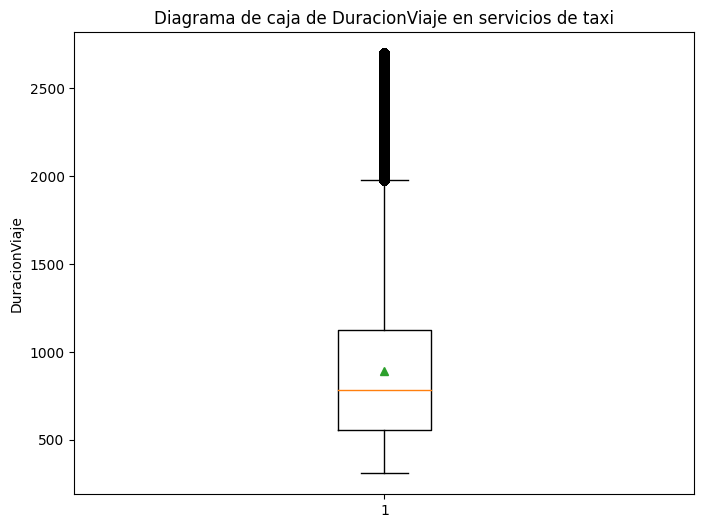

In [36]:
# Crear el diagrama de caja utilizando Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(df_sin_duplicados['DuracionViaje'], showmeans=True)

# Configurar títulos y etiquetas de ejes
plt.title('Diagrama de caja de DuracionViaje en servicios de taxi')
plt.ylabel('DuracionViaje')

# Mostrar el gráfico
plt.show()

In [37]:
# Calculamos nuevamente la media, mediana, desviación estándar, mínimo y máximo de la columna 'duracion_viaje'
mean_seconds = df_sin_duplicados['DuracionViaje'].mean()
median_seconds = df_sin_duplicados['DuracionViaje'].median()
std_seconds = df_sin_duplicados['DuracionViaje'].std()
min_seconds = df_sin_duplicados['DuracionViaje'].min()
max_seconds = df_sin_duplicados['DuracionViaje'].max()

# Revisar los resultados
print("Minimo:", min_seconds)
print("Maximo:", max_seconds)
print("Media:", mean_seconds)
print("Mediana:", median_seconds)
print("Desviación estándar:", std_seconds)

Minimo: 310
Maximo: 2700
Media: 890.7433925795087
Mediana: 786.0
Desviación estándar: 438.15242238574285


In [38]:
# Calcular la media, mediana, desviación estándar, mínimo y máximo de la columna:  'total_amount'
mean_seconds = df_sin_duplicados['CostoTotal'].mean()
median_seconds = df_sin_duplicados['CostoTotal'].median()
std_seconds = df_sin_duplicados['CostoTotal'].std()
min_seconds = df_sin_duplicados['CostoTotal'].min()
max_seconds = df_sin_duplicados['CostoTotal'].max()

# Revisar los resultados
print("Minimo:", min_seconds)
print("Maximo:", max_seconds)
print("Media:", mean_seconds)
print("Mediana:", median_seconds)
print("Desviación estándar:", std_seconds)

Minimo: 11.3
Maximo: 50.25
Media: 21.27079311990458
Mediana: 18.96
Desviación estándar: 8.168404928969714


**Matriz de correlación y visualizaciones**

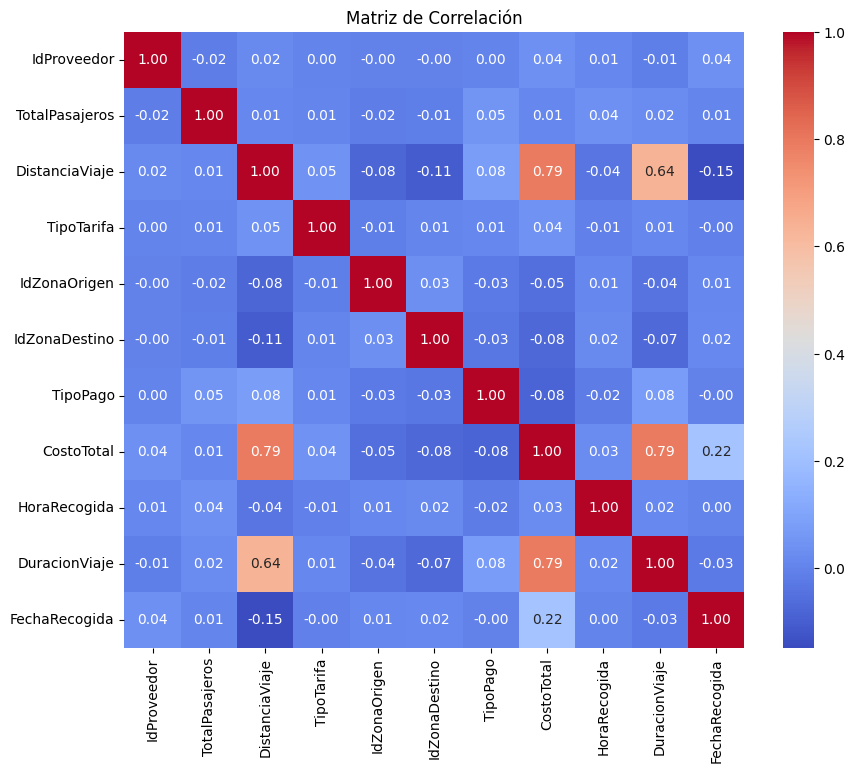

In [39]:
# Calcula la matriz de correlación
matriz_correlacion = df_sin_duplicados.corr()

# Crea un mapa de calor con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Matriz de Correlación')
plt.show()

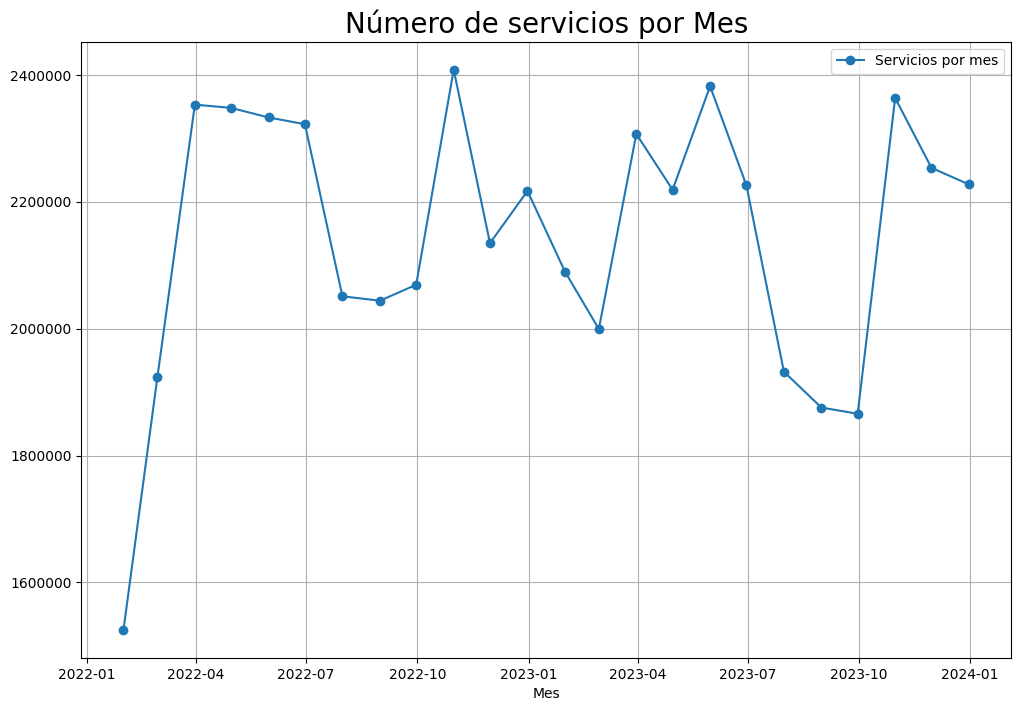

In [40]:
df_sin_duplicados['FechaRecogida'] = pd.to_datetime(df_sin_duplicados['FechaRecogida'])
grouped_data = df_sin_duplicados.resample('M', on='FechaRecogida').agg({'IdProveedor': 'count'}).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(grouped_data['FechaRecogida'], grouped_data['IdProveedor'], label='Servicios por mes', marker='o')
plt.title('Número de servicios por Mes', fontsize=20)
plt.xlabel('Mes')

# Desactivar la notación científica en el eje Y y mostrar los valores como enteros completos
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.grid(True)
plt.show()

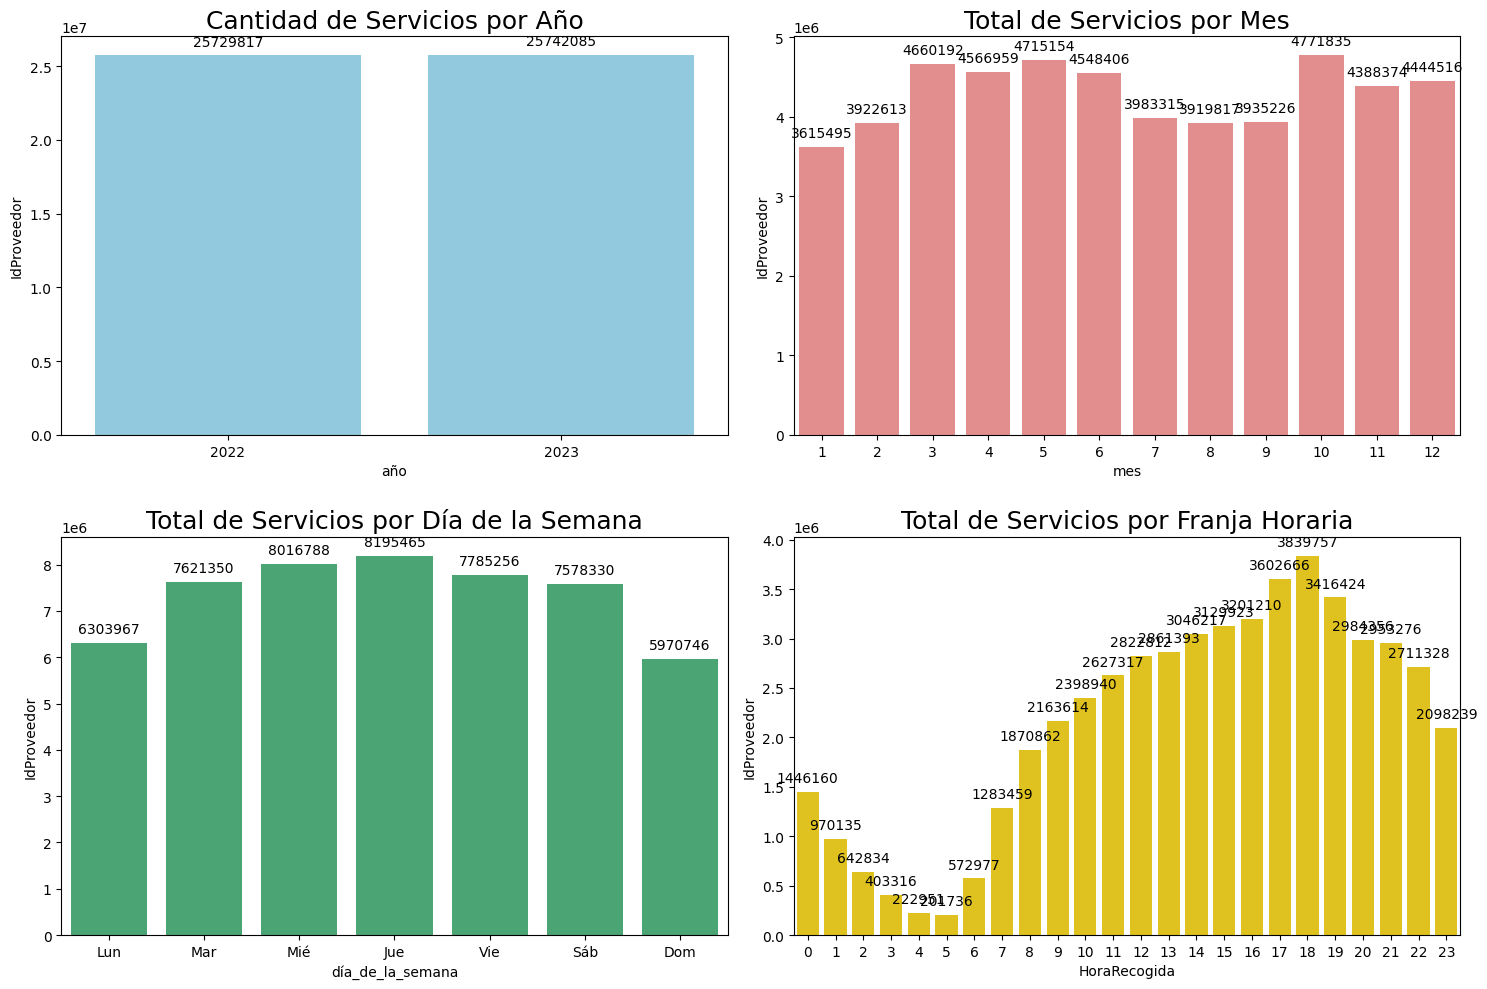

In [41]:
df_sin_duplicados['FechaRecogida'] = pd.to_datetime(df_sin_duplicados['FechaRecogida'])
df_sin_duplicados['año'] = df_sin_duplicados['FechaRecogida'].dt.year
df_sin_duplicados['mes'] = df_sin_duplicados['FechaRecogida'].dt.month
df_sin_duplicados['día_de_la_semana'] = df_sin_duplicados['FechaRecogida'].dt.day_name()

servicios_por_año = df_sin_duplicados.groupby('año')['IdProveedor'].count().reset_index()
servicios_por_mes = df_sin_duplicados.groupby('mes')['IdProveedor'].count().reset_index()
servicios_por_día_de_la_semana = df_sin_duplicados.groupby('día_de_la_semana')['IdProveedor'].count().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()
servicios_por_franja_hora = df_sin_duplicados.groupby('HoraRecogida')['IdProveedor'].count().reset_index()

# Se plotean 4 gráficos
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Cantidad de servicios por año
sns.barplot(x='año', y='IdProveedor', data=servicios_por_año, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Cantidad de Servicios por Año', fontsize=18)
for p in axs[0, 0].patches:
    axs[0, 0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

#Cantidad de servicios por mes
sns.barplot(x='mes', y='IdProveedor', data=servicios_por_mes, ax=axs[0, 1], color='lightcoral')
axs[0, 1].set_title('Total de Servicios por Mes', fontsize=18)
for p in axs[0, 1].patches:
    axs[0, 1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Cantidad de servicios por día
sns.barplot(x='día_de_la_semana', y='IdProveedor', data=servicios_por_día_de_la_semana, ax=axs[1, 0], color='mediumseagreen')
axs[1, 0].set_title('Total de Servicios por Día de la Semana', fontsize=18)
axs[1, 0].set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
for p in axs[1, 0].patches:
    axs[1, 0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

#Cantidad de servicios por franja horaria
sns.barplot(x='HoraRecogida', y='IdProveedor', data=servicios_por_franja_hora, ax=axs[1, 1], color='gold')
axs[1, 1].set_title('Total de Servicios por Franja Horaria', fontsize=18)
for p in axs[1, 1].patches:
    axs[1, 1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# EDA TAXIS FFVH
`En este cuadernillo se realiza el análisis exploratorio del dataset 'ffvh_analys'`

### Importación de librerías
---

*Para este cuaderno usaremos las siguientes librerías: **pandas, numpy, os, matplotlib, pathlib, seaborn, selenium y BeautifulSoup4**.*

In [ ]:
import os
import json
import math
import pandas as pd
from datetime import date, time
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
   
import dask  
import dask.dataframe as dd
import dask.array as da
    
from dask import delayed
from dask.distributed import Client, LocalCluster
import dask.multiprocessing
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Image, display

#### Web Scraping / Extracción de los datos
---

*Para este cuaderno usaremos .....*

1. 
2. 
3. 
4. 

In [ ]:
# from os import listdir
# from os.path import isfile, join
#fhvhv_tripdata_2022-01.parquet
## https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page <br> oks
# Configurar el clúster de Dask
cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit='6GB')
client = Client(cluster)
client

### Análisis exploratorio inicial
---

*Realizaremos una **exploración de los datos** (EDA) antes de hacer transformación de los mismos, esto con el fin de **conocer las columnas** y determinar que campos son importantes para nuestro análisis y así tener claridad con los pasos a seguir en el ETL.*

**Nota:**: *Posterior al ETL realizaremos también un EDA enfocado en los datos y una descripción estadística.*

#### **Revisión de la extracción de los datos** ####

*Revisamos que los datos se cargaron adecuadamente en nuestro dataframe **____**:*

1. *Usamos **head** para previsualizar los primeros registros del Dataframe.*

In [ ]:
head

#### **Revisión de la forma de los datos** ####

1. *Usamos **shape** obtener el número de filas y columnas del dataframe.*

In [ ]:
shape

#### **Exploración de las columnas** ####

*Vamos a revisar qué columnas existen en el dataframe y de qué tipo son:*

1. *Usamos el método **info()** para listar las columnas, su valores no nulos y sus tipos.*

info

#### **Búsqueda y eliminación de duplicados** ####

**Columna**